In [1]:
# Imports
import osmnx as ox
import networkx as nx
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import pandas as pd
from geopy.geocoders import Nominatim

# for bus functions
from shapely.geometry import Point
from shapely.ops import unary_union
import random

# traccess 
# r5py
# qgis
# matbox
# python-tsp

In [ ]:
class CalgaryTSP:
    def __init__(self):
        self.locations_bbox = None
        self.geolocator = Nominatim(user_agent="calgary_tsp")
        
        # Define main transit hubs
        self.transit_hubs = {
            'C-Train Stations': [
                ("Downtown West/Kerby", 51.0461, -114.0833),
                ("8th Street SW", 51.0461, -114.0789),
                ("7th Street SW", 51.0461, -114.0744),
                ("6th Street SW", 51.0461, -114.0700),
                ("3rd Street SW", 51.0461, -114.0567),
                ("City Hall", 51.0461, -114.0522),
                ("Erlton/Stampede", 51.0328, -114.0517),
                ("39th Avenue", 51.0219, -114.0517),
                ("Chinook", 50.9967, -114.0517),
                ("Heritage", 50.9883, -114.0517),
                ("Southland", 50.9633, -114.0517),
                ("Anderson", 50.9567, -114.0517),
                ("SAIT/ACAD/Jubilee", 51.0644, -114.0892),
                ("Lions Park", 51.0711, -114.0892),
                ("University", 51.0794, -114.1231),
                ("Brentwood", 51.0867, -114.1231),
                ("Dalhousie", 51.1042, -114.1231),
                ("Crowfoot", 51.1217, -114.1231),
                ("Tuscany", 51.1269, -114.2247)
            ],
            'Major Bus Terminals': [
                ("North Pointe Terminal", 51.1642, -114.0694),
                ("Brentwood Station", 51.0867, -114.1231),
                ("Lions Park Station", 51.0711, -114.0892),
                ("Anderson Station", 50.9567, -114.0517),
                ("Heritage Station", 50.9883, -114.0517),
                ("South Campus Hospital", 51.0794, -114.1231),
                ("Chinook Station", 50.9967, -114.0517)
            ]
        }
        
    def initialize_graph(self, locations):
        """Initialize graph based on locations"""
        # Get coordinates for all locations
        coords = []
        for loc in locations:
            location = self.geolocator.geocode(f"{loc}, Calgary, Alberta")
            if location:
                coords.append((location.latitude, location.longitude))
        
        # Add transit hub coordinates
        for hub_type in self.transit_hubs.values():
            for _, lat, lon in hub_type:
                coords.append((lat, lon))
        
        if not coords:
            raise ValueError("No valid locations found")
            
        # Calculate bounding box with padding
        min_lat = min(c[0] for c in coords)
        max_lat = max(c[0] for c in coords)
        min_lon = min(c[1] for c in coords)
        max_lon = max(c[1] for c in coords)
        
        # Add padding (about 20% of the range)
        lat_padding = (max_lat - min_lat) * 0.2
        lon_padding = (max_lon - min_lon) * 0.2
        
        self.locations_bbox = [
            min_lat - lat_padding,
            min_lon - lon_padding,
            max_lat + lat_padding,
            max_lon + lon_padding
        ]
        
        # Download graph for the specific area
        self.G = ox.graph_from_bbox(
            self.locations_bbox[0], self.locations_bbox[2],
            self.locations_bbox[1], self.locations_bbox[3],
            network_type='drive'
        )
        self.G_proj = ox.project_graph(self.G)

    def get_node_coordinates(self, address):
        """Get the nearest node coordinates for a given address"""
        try:
            location = self.geolocator.geocode(f"{address}, Calgary, Alberta")
            if location:
                nearest_node = ox.nearest_nodes(self.G, location.longitude, location.latitude)
                return nearest_node, (location.latitude, location.longitude)
        except Exception as e:
            print(f"Error geocoding {address}: {e}")
            return None, None

    def calculate_route_distance(self, node1, node2):
        """Calculate the actual driving distance between two nodes"""
        try:
            route = nx.shortest_path(self.G_proj, node1, node2, weight='length')
            return sum(ox.utils_graph.get_route_edge_attributes(self.G_proj, route, 'length'))
        except nx.NetworkXNoPath:
            return float('inf')

    def solve_tsp(self, locations):
        """Solve TSP for given locations"""
        self.initialize_graph(locations)
        
        nodes = []
        coords = []
        
        for loc in locations:
            node, coord = self.get_node_coordinates(loc)
            if node:
                nodes.append(node)
                coords.append(coord)
        
        n = len(nodes)
        if n < 2:
            return None, None, None
            
        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i != j:
                    distances[i][j] = self.calculate_route_distance(nodes[i], nodes[j])
                    
        best_distance = float('inf')
        best_route = None
        
        for route in permutations(range(n)):
            distance = sum(distances[route[i]][route[(i+1)%n]] for i in range(n))
            if distance < best_distance:
                best_distance = distance
                best_route = route
                
        return best_route, best_distance, nodes

    def plot_solution(self, locations, best_route, nodes):
        """Plot the solution with transit hubs"""
        plt.figure(figsize=(15, 10))
        ax = plt.axes([0.1, 0.1, 0.75, 0.8])
        
        # Plot base map
        ox.plot_graph(self.G, ax=ax, show=False, close=False, 
                     edge_color='gray', edge_alpha=0.2, node_size=0)
        
        # Plot routes
        colors = plt.cm.rainbow(np.linspace(0, 1, len(best_route)))
        legend_elements = []
        
        for i in range(len(best_route)):
            start = best_route[i]
            end = best_route[(i+1) % len(best_route)]
            
            route = nx.shortest_path(self.G, nodes[start], nodes[end], weight='length')
            
            route_coords = []
            for node in route:
                node_data = self.G.nodes[node]
                route_coords.append((node_data['y'], node_data['x']))
            route_coords = np.array(route_coords)
            
            line = ax.plot(route_coords[:, 1], route_coords[:, 0], 
                         color=colors[i], linewidth=2, alpha=0.7)[0]
            legend_elements.append((line, f'{locations[start]} → {locations[end]}'))
        
        # Plot location markers
        for i, route_idx in enumerate(best_route):
            loc = locations[route_idx]
            coord = self.geolocator.geocode(f"{loc}, Calgary, Alberta")
            if coord:
                ax.plot(coord.longitude, coord.latitude, 'o', 
                       color='red', markersize=10, zorder=5)
                ax.annotate(f"{i+1}. {loc}", 
                          xy=(coord.longitude, coord.latitude),
                          xytext=(5, 5), textcoords='offset points',
                          bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        
        # Plot transit hubs
        for hub_type, hubs in self.transit_hubs.items():
            if hub_type == 'C-Train Stations':
                marker = '^'  # triangle for C-Train
                color = 'blue'
                size = 3
            else:
                marker = 's'  # square for bus terminals
                color = 'green'
                size = 3
                
            # Plot each hub
            for name, lat, lon in hubs:
                ax.plot(lon, lat, marker, 
                       color=color, markersize=size, zorder=4,
                       label=hub_type if name == hubs[0][0] else "")
                
                # Add small labels for transit hubs
                ax.annotate(name, 
                          xy=(lon, lat),
                          xytext=(3, 3), 
                          textcoords='offset points',
                          fontsize=8,
                          bbox=dict(facecolor='white', 
                                  edgecolor='none', 
                                  alpha=0.7))
        
        # Create legend
        route_legend = [line for line, label in legend_elements]
        route_labels = [label for line, label in legend_elements]
        
        # Combine all legend elements
        ax.legend(route_legend + 
                 [plt.Line2D([0], [0], marker='^', color='blue', linestyle='none'),
                  plt.Line2D([0], [0], marker='s', color='green', linestyle='none')],
                 route_labels + ['C-Train Stations', 'Bus Terminals'],
                 bbox_to_anchor=(1.05, 1), loc='upper left',
                 borderaxespad=0.)
        
        plt.title("Optimal Route through Calgary Neighborhoods\nwith Transit Hubs")
        plt.tight_layout()
        plt.show()

In [ ]:
## Transit Hub Functions
def map_pickups_to_hub(self, hub_name, num_pickups, pickup_radius, given_pickups=None):
    """
    Map the best pickup and dropoff route to a transit hub.
    """
    # Find the hub coordinates
    hub_coords = None
    for hub_list in self.transit_hubs.values():
        for hub in hub_list:
            if hub[0] == hub_name:
                hub_coords = (hub[1], hub[2])
                break
        if hub_coords:
            break

    if not hub_coords:
        print(f"Transit hub {hub_name} not found.")
        return

    # Initialize the graph to set locations_bbox
    self.initialize_graph([f"{hub_coords[0]},{hub_coords[1]}"])

    # Generate or use given pickups
    if given_pickups is None:
        print("Generating random pickup locations...")
        pickups = self.generate_random_pickups(hub_coords, pickup_radius, num_pickups)
    else:
        pickups = given_pickups

    locations = [f"Pickup {i+1}" for i in range(len(pickups))] + [hub_name]
    coords = pickups + [hub_coords]

    print("Calculating optimal route...")
    nodes = [self.get_node_coordinates(f"{coord[0]},{coord[1]}")[0] for coord in coords]
    nodes = [n for n in nodes if n is not None]

    if len(nodes) < 2:
        print("Not enough valid locations for a route.")
        return

    best_route, total_distance, _ = self.solve_tsp(locations)

    if best_route is None:
        print("Couldn't find valid route.")
        return

    print("\nOptimal Route:")
    for idx in best_route:
        print(locations[idx])
    print(f"Total Distance: {total_distance / 1000:.2f} km")

    # Visualize the route
    self.plot_solution(locations, best_route, nodes)

def generate_random_pickups(self, center, radius, num_pickups):
    """
    Generate random pickup locations on the street network within a given radius of a center point.
    """
    center_node = ox.nearest_nodes(self.G, center[1], center[0])
    pickup_nodes = []
    
    while len(pickup_nodes) < num_pickups:
        # Get all nodes within the radius
        nearby_nodes = ox.nearest_nodes(self.G, center[1], center[0], return_dist=True)
        nearby_nodes = [node for node, dist in zip(*nearby_nodes) if dist <= radius * 1000]  # Convert km to meters
        
        if not nearby_nodes:
            print(f"No nodes found within {radius} km of the center. Increasing search radius.")
            radius *= 1.5
            continue
        
        # Randomly select a node
        random_node = random.choice(nearby_nodes)
        if random_node not in pickup_nodes:
            pickup_nodes.append(random_node)
    
    # Convert nodes to lat, lon coordinates
    pickups = [(self.G.nodes[node]['y'], self.G.nodes[node]['x']) for node in pickup_nodes]
    return pickups


In [25]:
# COMBINED FUNCTION IMPLEMENTATIONS 

class CalgaryTSP:
    def __init__(self):
        self.locations_bbox = None
        self.geolocator = Nominatim(user_agent="calgary_tsp")
        # Define main transit hubs
        self.transit_hubs = {
            'C-Train Stations': [
                ("Downtown West/Kerby", 51.0461, -114.0833),
                ("8th Street SW", 51.0461, -114.0789),
                ("7th Street SW", 51.0461, -114.0744),
                ("6th Street SW", 51.0461, -114.0700),
                ("3rd Street SW", 51.0461, -114.0567),
                ("City Hall", 51.0461, -114.0522),
                ("Erlton/Stampede", 51.0328, -114.0517),
                ("39th Avenue", 51.0219, -114.0517),
                ("Chinook", 50.9967, -114.0517),
                ("Heritage", 50.9883, -114.0517),
                ("Southland", 50.9633, -114.0517),
                ("Anderson", 50.9567, -114.0517),
                ("SAIT/ACAD/Jubilee", 51.0644, -114.0892),
                ("Lions Park", 51.0711, -114.0892),
                ("University", 51.0794, -114.1231),
                ("Brentwood", 51.0867, -114.1231),
                ("Dalhousie", 51.1042, -114.1231),
                ("Crowfoot", 51.1217, -114.1231),
                ("Tuscany", 51.1269, -114.2247)
            ],
            'Major Bus Terminals': [
                ("North Pointe Terminal", 51.1642, -114.0694),
                ("Brentwood Station", 51.0867, -114.1231),
                ("Lions Park Station", 51.0711, -114.0892),
                ("Anderson Station", 50.9567, -114.0517),
                ("Heritage Station", 50.9883, -114.0517),
                ("South Campus Hospital", 51.0794, -114.1231),
                ("Chinook Station", 50.9967, -114.0517)
            ]
        }

    def initialize_graph(self, locations):
        """Initialize graph based on locations"""
        # Get coordinates for all locations
        coords = []
        for loc in locations:
            location = self.geolocator.geocode(f"{loc}, Calgary, Alberta")
            if location:
                coords.append((location.latitude, location.longitude))
        # Add transit hub coordinates
        for hub_type in self.transit_hubs.values():
            for _, lat, lon in hub_type:
                coords.append((lat, lon))
        
        if not coords:
            raise ValueError("No valid locations found")
        
        # Calculate bounding box with padding
        min_lat = min(c[0] for c in coords)
        max_lat = max(c[0] for c in coords)
        min_lon = min(c[1] for c in coords)
        max_lon = max(c[1] for c in coords)
        
        # Add padding (about 20% of the range)
        lat_padding = (max_lat - min_lat) * 0.2
        lon_padding = (max_lon - min_lon) * 0.2
        self.locations_bbox = [
            min_lat - lat_padding,
            min_lon - lon_padding,
            max_lat + lat_padding,
            max_lon + lon_padding
        ]
        
        # Download graph for the specific area
        self.G = ox.graph_from_bbox(
            self.locations_bbox[0], self.locations_bbox[2],
            self.locations_bbox[1], self.locations_bbox[3],
            network_type='drive'
        )
        self.G_proj = ox.project_graph(self.G)
        
        print(f"Graph initialized with bounding box: {self.locations_bbox}")

    def get_node_coordinates(self, address):
        """Get the nearest node coordinates for a given address"""
        try:
            location = self.geolocator.geocode(f"{address}, Calgary, Alberta")
            if location:
                nearest_node = ox.nearest_nodes(self.G, location.longitude, location.latitude)
                return nearest_node, (location.latitude, location.longitude)
        except Exception as e:
            print(f"Error geocoding {address}: {e}")
        return None, None

    def calculate_route_distance(self, node1, node2):
        """Calculate the actual driving distance between two nodes"""
        try:
            route = nx.shortest_path(self.G_proj, node1, node2, weight='length')
            return sum(ox.utils_graph.get_route_edge_attributes(self.G_proj, route, 'length'))
        except nx.NetworkXNoPath:
            return float('inf')

    def solve_tsp(self, locations, nodes):
        """Solve TSP for given locations and nodes"""
        n = len(nodes)
        if n < 2:
            print("Not enough nodes to solve TSP.")
            return None, None, None

        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i != j:
                    try:
                        distances[i][j] = nx.shortest_path_length(self.G, nodes[i], nodes[j], weight='length')
                    except nx.NetworkXNoPath:
                        print(f"No path found between nodes {i} and {j}")
                        distances[i][j] = float('inf')

        if np.isinf(distances).all():
            print("No valid paths found between any nodes.")
            return None, None, None

        best_distance = float('inf')
        best_route = None
        for route in permutations(range(n)):
            distance = sum(distances[route[i]][route[(i+1)%n]] for i in range(n))
            if distance < best_distance:
                best_distance = distance
                best_route = route

        if best_route is None:
            print("Couldn't find a valid route.")
            return None, None, None

        return best_route, best_distance, nodes

    def plot_solution(self, locations, best_route, nodes):
        """Plot the solution with transit hubs"""
        plt.figure(figsize=(15, 10))
        ax = plt.axes([0.1, 0.1, 0.75, 0.8])

        # Plot base map
        ox.plot_graph(self.G, ax=ax, show=False, close=False,
                    edge_color='gray', edge_alpha=0.2, node_size=0)

        # Plot routes if we have a best_route
        if best_route is not None:
            colors = plt.cm.rainbow(np.linspace(0, 1, len(best_route)))
            legend_elements = []
            for i in range(len(best_route)):
                start = best_route[i]
                end = best_route[(i+1) % len(best_route)]
                route = nx.shortest_path(self.G, nodes[start], nodes[end], weight='length')
                route_coords = []
                for node in route:
                    node_data = self.G.nodes[node]
                    route_coords.append((node_data['y'], node_data['x']))
                route_coords = np.array(route_coords)
                line = ax.plot(route_coords[:, 1], route_coords[:, 0],
                            color=colors[i], linewidth=2, alpha=0.7)[0]
                legend_elements.append((line, f'{locations[start]} → {locations[end]}'))

        # Plot location markers
        for i, loc in enumerate(locations):
            coord = self.geolocator.geocode(f"{loc}, Calgary, Alberta")
            if coord:
                ax.plot(coord.longitude, coord.latitude, 'o',
                        color='red', markersize=10, zorder=5)
                ax.annotate(f"{i+1}. {loc}",
                            xy=(coord.longitude, coord.latitude),
                            xytext=(5, 5), textcoords='offset points',
                            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

        # Plot transit hubs
        for hub_type, hubs in self.transit_hubs.items():
            if hub_type == 'C-Train Stations':
                marker = '^'  # triangle for C-Train
                color = 'blue'
                size = 8
            else:
                marker = 's'  # square for bus terminals
                color = 'green'
                size = 8
            
            # Plot each hub
            for name, lat, lon in hubs:
                ax.plot(lon, lat, marker,
                        color=color, markersize=size, zorder=4,
                        label=hub_type if name == hubs[0][0] else "")
                # Add small labels for transit hubs
                ax.annotate(name,
                            xy=(lon, lat),
                            xytext=(3, 3),
                            textcoords='offset points',
                            fontsize=8,
                            bbox=dict(facecolor='white',
                                    edgecolor='none',
                                    alpha=0.7))

        # Create legend
        if best_route is not None:
            route_legend = [line for line, label in legend_elements]
            route_labels = [label for line, label in legend_elements]
            # Combine all legend elements
            ax.legend(route_legend +
                    [plt.Line2D([0], [0], marker='^', color='blue', linestyle='none'),
                    plt.Line2D([0], [0], marker='s', color='green', linestyle='none')],
                    route_labels + ['C-Train Stations', 'Bus Terminals'],
                    bbox_to_anchor=(1.05, 1), loc='upper left',
                    borderaxespad=0.)
        else:
            ax.legend([plt.Line2D([0], [0], marker='^', color='blue', linestyle='none'),
                    plt.Line2D([0], [0], marker='s', color='green', linestyle='none')],
                    ['C-Train Stations', 'Bus Terminals'],
                    bbox_to_anchor=(1.05, 1), loc='upper left',
                    borderaxespad=0.)

        plt.title("Calgary Transit Map with Pickup Locations")
        plt.tight_layout()
        plt.show()

    def map_pickups_to_hub(self, hub_name, num_pickups, pickup_radius, given_pickups=None):
        """
        Map the best pickup and dropoff route to a transit hub.
        """
        # Find the hub coordinates
        hub_coords = None
        for hub_list in self.transit_hubs.values():
            for hub in hub_list:
                if hub[0] == hub_name:
                    hub_coords = (hub[1], hub[2])
                    break
            if hub_coords:
                break

        if not hub_coords:
            print(f"Transit hub {hub_name} not found.")
            return

        print(f"Hub coordinates: {hub_coords}")

        # Initialize the graph to set locations_bbox
        self.initialize_graph([f"{hub_coords[0]},{hub_coords[1]}"])

        # Generate or use given pickups
        if given_pickups is None:
            print("Generating random pickup locations...")
            pickups = self.generate_random_pickups(hub_coords, pickup_radius, num_pickups)
        else:
            pickups = given_pickups

        print(f"Generated pickup locations: {pickups}")

        locations = [f"Pickup {i+1}" for i in range(len(pickups))] + [hub_name]
        coords = pickups + [hub_coords]

        print("Calculating optimal route...")
        nodes = [ox.nearest_nodes(self.G, coord[1], coord[0]) for coord in coords]
        print(f"Valid nodes: {nodes}")

        if len(nodes) < 2:
            print("Not enough valid locations for a route.")
            return

        best_route, total_distance, _ = self.solve_tsp(locations, nodes)

        if best_route is None:
            print("Couldn't find valid route.")
        else:
            print("\nOptimal Route:")
            for idx in best_route:
                print(locations[idx])
            print(f"Total Distance: {total_distance / 1000:.2f} km")

        # Visualize the route
        self.plot_solution(locations, best_route, nodes)
        
    def generate_random_pickups(self, center, radius, num_pickups):
        """
        Generate random pickup locations on the street network within a given radius of a center point.
        """
        center_node = ox.nearest_nodes(self.G, center[1], center[0])
        pickup_nodes = []
        
        # Convert radius from km to meters
        radius_m = radius * 1000
        
        while len(pickup_nodes) < num_pickups:
            # Generate a random angle and distance
            angle = random.uniform(0, 2 * np.pi)
            distance = random.uniform(0, radius_m)
            
            # Calculate new point
            dx = distance * np.cos(angle)
            dy = distance * np.sin(angle)
            
            # Convert to lat/lon
            new_lon = center[1] + (dx / (111320 * np.cos(np.radians(center[0]))))
            new_lat = center[0] + (dy / 110540)
            
            # Find nearest node to this point
            nearest_node = ox.nearest_nodes(self.G, new_lon, new_lat)
            
            if nearest_node not in pickup_nodes:
                pickup_nodes.append(nearest_node)
        
        # Convert nodes to lat, lon coordinates
        pickups = [(self.G.nodes[node]['y'], self.G.nodes[node]['x']) for node in pickup_nodes]
        return pickups

Hub coordinates: (51.1642, -114.0694)


C:\Users\bilal\AppData\Local\Temp\ipykernel_37832\1676305191.py:74: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  self.G = ox.graph_from_bbox(
C:\Users\bilal\AppData\Local\Temp\ipykernel_37832\1676305191.py:74: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  self.G = ox.graph_from_bbox(


Graph initialized with bounding box: [50.9152, -114.2593, 51.2057, -114.0171]
Generating random pickup locations...
Generated pickup locations: [(51.1535498, -114.0830308), (51.1695532, -114.0822576), (51.1745623, -114.1021689), (51.1588666, -114.0702251), (51.1621681, -114.0572448)]
Calculating optimal route...
Valid nodes: [4750873408, 2040034141, 1446735913, 1449264715, 360098032, 1449264800]

Optimal Route:
Pickup 1
Pickup 3
Pickup 2
North Pointe Terminal
Pickup 5
Pickup 4
Total Distance: 16.27 km


C:\Users\bilal\AppData\Local\Temp\ipykernel_37832\1676305191.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


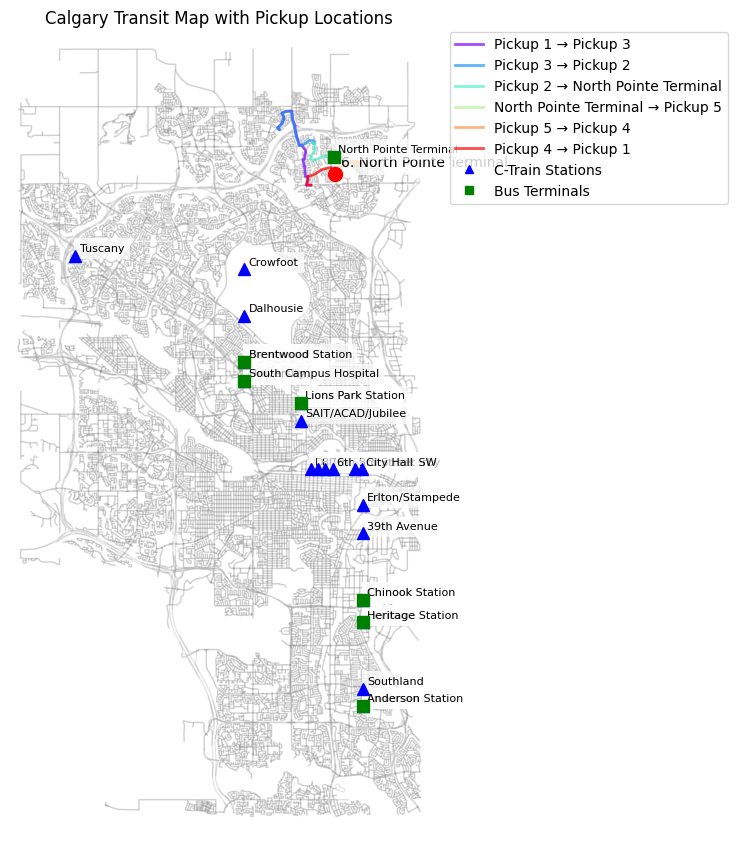

In [27]:
# solver = CalgaryTSP()
# map_pickups_to_hub(hub_name="Chinook", num_pickups=3, pickup_radius=2) # 3 random pickups 3kms around chinook

def main():
    solver = CalgaryTSP()
    # solver.map_pickups_to_hub("Chinook", 5, 3)  # 3 random pickups within 2km of Chinook station
    solver.map_pickups_to_hub(hub_name="North Pointe Terminal", num_pickups=5, pickup_radius=3) # 3 random pickups 3kms around chinook

if __name__ == "__main__":
    main()

Calculating optimal route...


C:\Users\bilal\AppData\Local\Temp\ipykernel_38936\935574263.py:75: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  self.G = ox.graph_from_bbox(
C:\Users\bilal\AppData\Local\Temp\ipykernel_38936\935574263.py:75: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  self.G = ox.graph_from_bbox(
C:\Users\bilal\AppData\Local\Temp\ipykernel_38936\935574263.py:97: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return sum(ox.utils_graph.get_route_edge_attributes(self.G_proj, route, 'length'))



Optimal Route:
-------------
1. Downtown Core, Calgary
2. Kensington, Calgary
3. University Heights, Calgary
4. Bowness, Calgary
5. Signal Hill, Calgary
6. Beltline, Calgary
7. Inglewood, Calgary
8. Bridgeland, Calgary

Total Distance: 42.07 km

Generating map visualization...


C:\Users\bilal\AppData\Local\Temp\ipykernel_38936\935574263.py:216: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


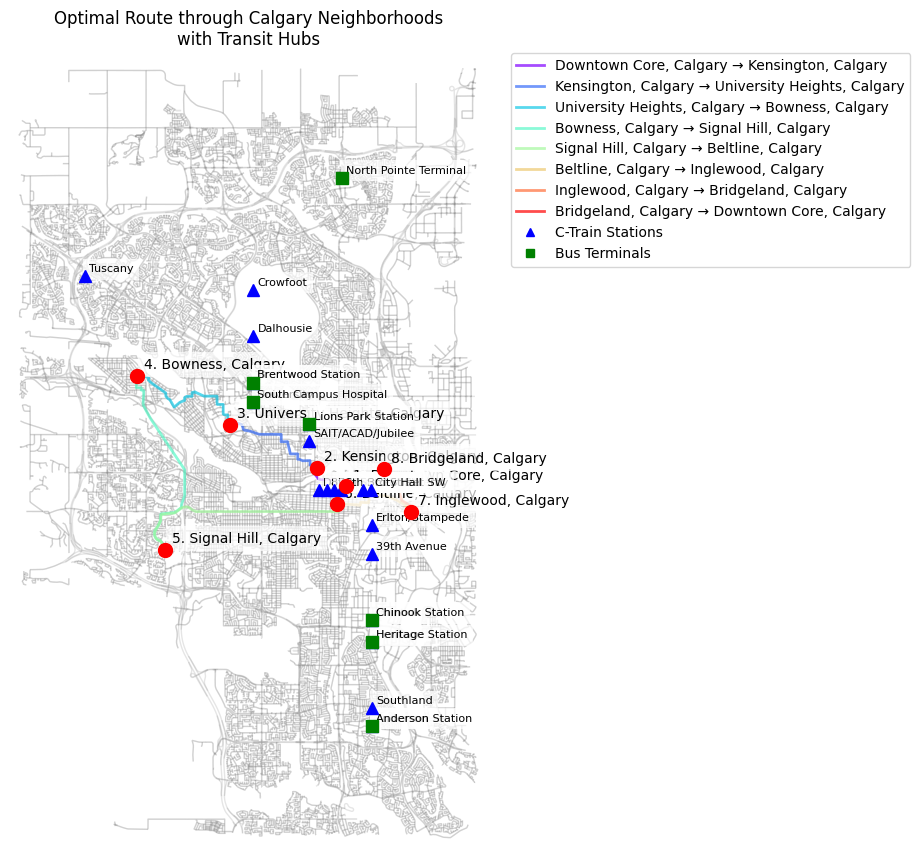

In [7]:
def main():
    locations = [
        "Downtown Core, Calgary",
        "Kensington, Calgary",
        "Beltline, Calgary",
        "Bowness, Calgary",
        "Inglewood, Calgary",
        "University Heights, Calgary",
        "Signal Hill, Calgary",
        "Bridgeland, Calgary"
    ]
    
    solver = CalgaryTSP()
    
    print("Calculating optimal route...")
    best_route, total_distance, nodes = solver.solve_tsp(locations)
    
    if best_route is None:
        print("Couldn't find valid route")
        return
        
    print("\nOptimal Route:")
    print("-------------")
    for i, idx in enumerate(best_route):
        print(f"{i+1}. {locations[idx]}")
    print(f"\nTotal Distance: {total_distance/1000:.2f} km")
    
    print("\nGenerating map visualization...")
    solver.plot_solution(locations, best_route, nodes)

if __name__ == "__main__":
    main()